# Problem 3: Identifying vowels independent of speaker using spectral features - MFCC

## 1. Import library, parameters and functions

In [3]:
import math
import librosa
import librosa.display
import numpy as np
from scipy.signal.windows import hamming, bartlett, blackman, kaiser, hann
from sklearn.cluster import KMeans
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
FRAME_SIZE = 0.03
FRAME_SHIFT = 0.015
MFCC_POINTS = 13
THRESHOLD = 0.01
K = 2

FRAMES_MODES = [(0.03, 0.015), (0.02, 0.01)]
WINDOW_FUNCTIONS=['hamming', 'bartlett',  'kaiser']
K_CLUSTERS = [2,3,4,5]

VOWEL_LIST = ['a', 'e', 'i', 'o', 'u']

# Tập huấn luyện
TRAINING_DATA = [
    'NguyenAmHuanLuyen-16k/45MDV',
    'NguyenAmHuanLuyen-16k/23MTL',
    'NguyenAmHuanLuyen-16k/24FTL',
    'NguyenAmHuanLuyen-16k/25MLM',
    'NguyenAmHuanLuyen-16k/27MCM',
    'NguyenAmHuanLuyen-16k/28MVN',
    'NguyenAmHuanLuyen-16k/29MHN',
    'NguyenAmHuanLuyen-16k/30FTN',
    'NguyenAmHuanLuyen-16k/32MTP',
    'NguyenAmHuanLuyen-16k/33MHP',
    'NguyenAmHuanLuyen-16k/34MQP',
    'NguyenAmHuanLuyen-16k/35MMQ',
    'NguyenAmHuanLuyen-16k/36MAQ',
    'NguyenAmHuanLuyen-16k/37MDS',
    'NguyenAmHuanLuyen-16k/38MDS',
    'NguyenAmHuanLuyen-16k/39MTS',
    'NguyenAmHuanLuyen-16k/40MHS',
    'NguyenAmHuanLuyen-16k/41MVS',
    'NguyenAmHuanLuyen-16k/42FQT',
    'NguyenAmHuanLuyen-16k/43MNT',
    'NguyenAmHuanLuyen-16k/44MTT']

# Tập kiểm thử
VALIDATING_DATA = [
    'NguyenAmKiemThu-16k/01MDA',
    'NguyenAmKiemThu-16k/02FVA',
    'NguyenAmKiemThu-16k/03MAB',
    'NguyenAmKiemThu-16k/04MHB',
    'NguyenAmKiemThu-16k/05MVB',
    'NguyenAmKiemThu-16k/06FTB',
    'NguyenAmKiemThu-16k/07FTC',
    'NguyenAmKiemThu-16k/08MLD',
    'NguyenAmKiemThu-16k/09MPD',
    'NguyenAmKiemThu-16k/10MSD',
    'NguyenAmKiemThu-16k/11MVD',
    'NguyenAmKiemThu-16k/12FTD',
    'NguyenAmKiemThu-16k/14FHH',
    'NguyenAmKiemThu-16k/15MMH',
    'NguyenAmKiemThu-16k/16FTH',
    'NguyenAmKiemThu-16k/17MTH',
    'NguyenAmKiemThu-16k/18MNK',
    'NguyenAmKiemThu-16k/19MXK',
    'NguyenAmKiemThu-16k/20MVK',
    'NguyenAmKiemThu-16k/21MTL',
    'NguyenAmKiemThu-16k/22MHL']

In [5]:
def load_audio(file_path):
    """
    Load audio file and return the audio signal and sample rate.

    Parameters:
    - file_path (str): Path to the audio file.

    Returns:
    - tuple: A tuple containing the audio signal and sample rate.
    """
    try:
        audio, sr = librosa.load(file_path, sr=None)
        return audio, sr
    except Exception as e:
        print(f"Error loading audio: {e}")
        return None, None


def frame_audio(audio, framesize, frameshift):
    """
    Frame the audio signal with the given framesize and frameshift.

    Parameters:
    - audio (np.ndarray): Audio signal.
    - framesize (int): Length of each frame.
    - frameshift (int): Hop length between frames.

    Returns:
    - np.ndarray: Framed audio.
    """
    return librosa.util.frame(audio, frame_length=framesize, hop_length=frameshift)


def compute_ste(framed_audio):
    """
    Compute Short-Time Energy (STE) for each frame.

    Parameters:
    - framed_audio (np.ndarray): Framed audio signal.

    Returns:
    - np.ndarray: Short-Time Energy values.
    """
    ste = np.sum(np.square(framed_audio), axis=0)
    ste /= np.max(ste)
    return ste


def find_stable_border(ste):
    """
    Find the stable region in the Short-Time Energy (STE) values.

    Parameters:
    - ste (np.ndarray): Short-Time Energy values.

    Returns:
    - tuple: Left and right borders of the stable region.
    """
    left_border, right_border = None, None

    for i in range(len(ste)):
        if ste[i] > THRESHOLD:
            left_border = i
            break

    for i in range(len(ste) - 1, -1, -1):
        if ste[i] > THRESHOLD:
            right_border = i
            break

    left_stable_border = left_border + (right_border - left_border) // 3
    right_stable_border = right_border - (right_border - left_border) // 3

    return left_stable_border, right_stable_border


def extract_vectorMFCC(audio_signal, sample_rate):
    """
    Extract MFCC feature vectors from an audio signal.

    Parameters:
    - audio_signal (np.ndarray): Audio signal.
    - sample_rate (int): Sample rate.

    Returns:
    - np.ndarray: MFCC feature vectors.
    """
    frame_shift = int(FRAME_SHIFT * sample_rate)
    frame_len = int(FRAME_SIZE * sample_rate)
    frame_num = (len(audio_signal) - frame_len) // frame_shift + 1

    hamming_window = hamming(frame_len)
    mfcc_vectors = []

    for i in range(frame_num):
        start_index = i * frame_shift
        end_index = start_index + frame_len
        frame = audio_signal[start_index:end_index]
        windowed_frame = frame * hamming_window

        # Compute MFCC for the frame
        mfcc_vectors.append(librosa.feature.mfcc(y=windowed_frame, n_fft=512, sr=sample_rate, n_mfcc=MFCC_POINTS).T)

    mfcc_array = np.array(mfcc_vectors)
    normalized_array = mfcc_array / np.max(np.abs(mfcc_array))
    return normalized_array


def extract_feature_vector(speaker, vowel):
    """
    Extract the feature vector of 1 speaker with 1 vowel.

    Parameters:
    - speaker (str): Speaker identifier.
    - vowel (str): Vowel identifier.

    Returns:
    - np.ndarray: MFCC feature vector.
    """
    file_path = f'signals/{speaker}/{vowel}.wav'
    audio, sr = load_audio(file_path)

    framesize = int(FRAME_SIZE * sr)
    frameshift = int(FRAME_SHIFT * sr)

    framed_audio = frame_audio(audio, framesize, frameshift)
    ste = compute_ste(framed_audio)

    left_stable_border, right_stable_border = find_stable_border(ste)

    left_stable_sample = int(left_stable_border * frameshift)
    right_stable_sample = int(right_stable_border * frameshift)

    stable_region = audio[left_stable_sample:right_stable_sample]

    mfcc_vector = extract_vectorMFCC(stable_region, sr)
    return mfcc_vector


def compute_kmean_feature_vector(speakers, vowel, K):
    """
    Compute the average feature vector for a given vowel across multiple speakers.

    Parameters:
    - speakers (list): List of speaker identifiers.
    - vowel (str): Vowel identifier.

    Returns:
    - np.ndarray: Average feature vector.
    """
    all_feature_vectors = []

    for speaker in speakers:
        feature_vector = extract_feature_vector(speaker, vowel)
        all_feature_vectors.extend(feature_vector)

    all_feature_vectors = np.array(all_feature_vectors)
    normalized_array = all_feature_vectors / np.max(np.abs(all_feature_vectors))
    flattened_array = normalized_array.reshape(normalized_array.shape[0], -1)

    kmeans = KMeans(n_clusters=K, random_state=0)
    kmeans.fit(flattened_array)
    centroids = kmeans.cluster_centers_
    return centroids


def extract_speaker_feature_vector(speaker, vowel):
    """
    Extract the feature vector of 1 speaker with 1 vowel.

    Parameters:
    - speaker (str): Speaker identifier.
    - vowel (str): Vowel identifier.

    Returns:
    - np.ndarray: MFCC feature vector.
    """
    file_path = f'signals/{speaker}/{vowel}.wav'
    audio, sr = load_audio(file_path)

    framesize = int(FRAME_SIZE * sr)
    frameshift = int(FRAME_SHIFT * sr)

    framed_audio = frame_audio(audio, framesize, frameshift)
    ste = compute_ste(framed_audio)

    left_stable_border, right_stable_border = find_stable_border(ste)

    left_stable_sample = int(left_stable_border * frameshift)
    right_stable_sample = int(right_stable_border * frameshift)

    stable_region = audio[left_stable_sample:right_stable_sample]

    mfcc_vector = extract_vectorMFCC(stable_region, sr)
    mfcc_vector = np.mean(mfcc_vector, axis=0).reshape(-1, 1)
    return mfcc_vector


def find_accuracy_according_to_K(K=2):
    """
    Find the accuracy according to the value of K.

    Parameters:
    - K (int): Number of clusters for K-means.

    Returns:
    - float: Accuracy.
    """
    vowel_kmean_vector = defaultdict(list)
    vowel_kmean_vector['a'] = compute_kmean_feature_vector(TRAINING_DATA, 'a', K)
    vowel_kmean_vector['e'] = compute_kmean_feature_vector(TRAINING_DATA, 'e', K)
    vowel_kmean_vector['i'] = compute_kmean_feature_vector(TRAINING_DATA, 'i', K)
    vowel_kmean_vector['o'] = compute_kmean_feature_vector(TRAINING_DATA, 'o', K)
    vowel_kmean_vector['u'] = compute_kmean_feature_vector(TRAINING_DATA, 'u', K)


    result = 0
    distance = defaultdict(lambda:10**9)
    for speaker in VALIDATING_DATA:
        for vowel in VOWEL_LIST:
            speaker_feature_vector = extract_speaker_feature_vector(speaker, vowel)
            distance.clear()
            for i in range(K):
                distance['a'] = min(distance['a'], euclidean_distance(speaker_feature_vector,vowel_kmean_vector['a'][i]))
                distance['e'] = min(distance['e'], euclidean_distance(speaker_feature_vector,vowel_kmean_vector['e'][i]))
                distance['i'] = min(distance['i'], euclidean_distance(speaker_feature_vector,vowel_kmean_vector['i'][i]))
                distance['o'] = min(distance['o'], euclidean_distance(speaker_feature_vector,vowel_kmean_vector['o'][i]))
                distance['u'] = min(distance['u'], euclidean_distance(speaker_feature_vector,vowel_kmean_vector['u'][i]))

            min_distance = min(distance.values())
            if min_distance == distance['a']:
                result += ('a'==vowel)
            elif min_distance == distance['e']:
                result += ('e'==vowel)
            elif min_distance == distance['i']:
                result += ('i'==vowel)
            elif min_distance == distance['o']:
                result += ('o'==vowel)
            else:
                result += ('u'==vowel)

    accuracy = result / (len(VALIDATING_DATA) * len(VOWEL_LIST))
    return accuracy


def euclidean_distance(vector1, vector2):
    """
    Compute the Euclidean distance between two vectors.

    Parameters:
    - vector1 (np.ndarray): First vector.
    - vector2 (np.ndarray): Second vector.

    Returns:
    - float: Euclidean distance.
    """
    distance = 0
    for i in range(13):
        distance += (vector1[i] - vector2[i])**2
    return math.sqrt(distance)


## 2. Visualizing MFCC Feature vectors of vowels

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=480
  warnings.warn(


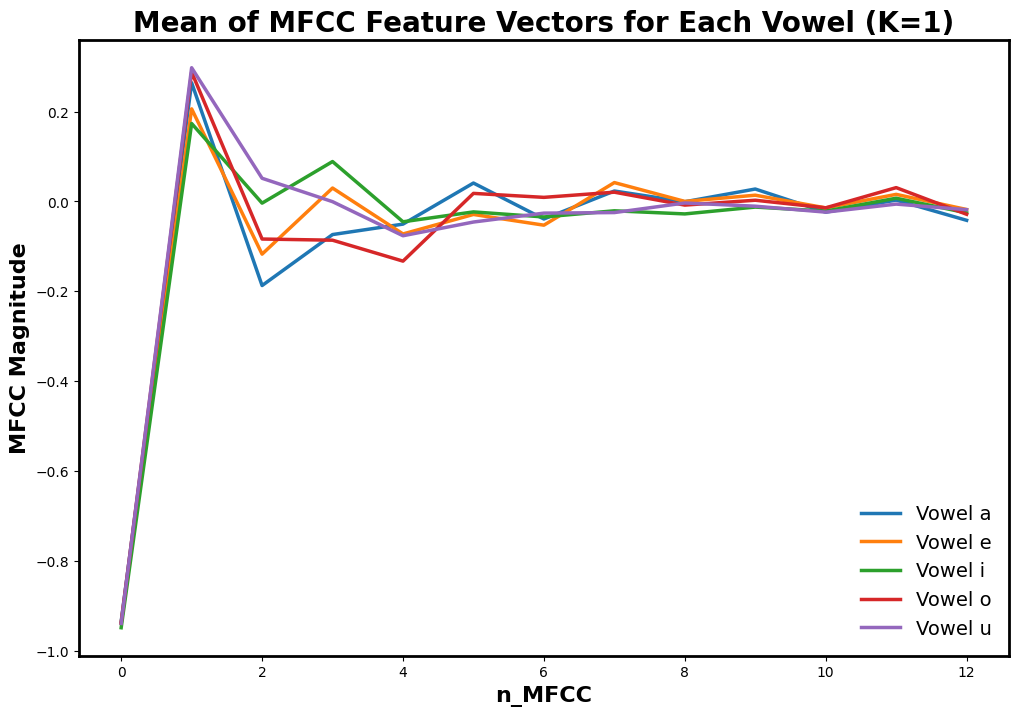

In [6]:
def compute_MFCC_feature_vector(speakers, vowel):
    """
    Compute the average feature vector for a given vowel across multiple speakers.

    Parameters:
    - speakers (list): List of speaker identifiers.
    - vowel (str): Vowel identifier.

    Returns:
    - np.ndarray: Average feature vector.
    """
    all_feature_vectors = []

    for speaker in speakers:
        feature_vector = extract_feature_vector(speaker, vowel)
        all_feature_vectors.extend(feature_vector)

    all_feature_vectors = np.array(all_feature_vectors)
    normalized_array = all_feature_vectors / np.max(np.abs(all_feature_vectors))
    
    # Compute the mean along the axis 0 (across feature vectors)
    mean_feature_vector = np.mean(normalized_array, axis=0)
    
    return mean_feature_vector

    
vowel_MFCC_vector = defaultdict(list)

for vowel in VOWEL_LIST:
    vowel_MFCC_vector[vowel] = compute_MFCC_feature_vector(TRAINING_DATA, vowel)[0]
    
    
# Khởi tạo một hình vẽ với kích thước lớn hơn và viền đen bọc ở ngoài
fig, ax = plt.subplots(figsize=(12, 8))

# Set the border color and width of the plot
for spine in ax.spines.values():

    spine.set_color('black')

    spine.set_linewidth(2)

# Turn off the grid in the plot
ax.grid(False)

# Vẽ đồ thị cho từng nguyên âm
for i, vowel in enumerate(VOWEL_LIST):
    ax.plot(vowel_MFCC_vector[vowel], label=f'Vowel {vowel}', linewidth=2.5)

# Set larger and bolder titles and axis labels
ax.set_title('Mean of MFCC Feature Vectors for Each Vowel (K=1)', fontsize=20, fontweight='bold')
ax.set_xlabel('n_MFCC', fontsize=16, fontweight='bold')
ax.set_ylabel('MFCC Magnitude', fontsize=16, fontweight='bold')

# Configure the legend to have a larger font size and without a frame
ax.legend(frameon=False, fontsize=14)

# Show the plot
plt.show()

## 3. Finding optimal value of K using Elbow Method and statistics

### 3.1 Finding optimal value using Elbow method

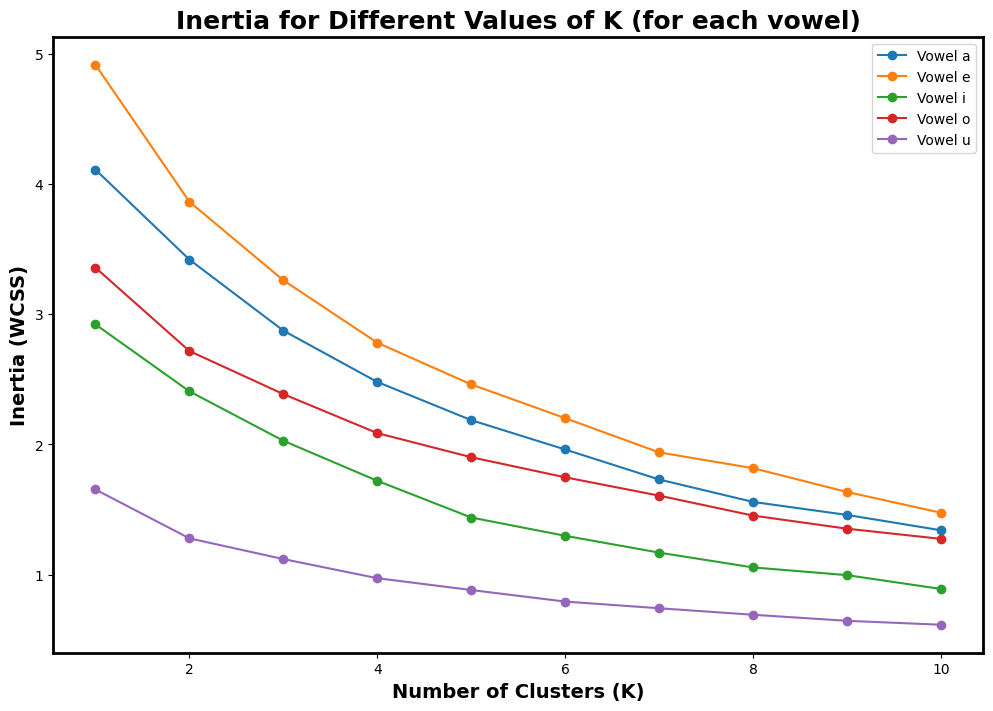

In [7]:
# Ignore warnings
warnings.filterwarnings("ignore")

def calculate_inertia(data, max_k):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    return inertia

vowel_list = ['a', 'e', 'i', 'o', 'u']
max_k = 10  # Set the maximum value of K to try

# Create a figure and axis with future customizations
fig, ax = plt.subplots(figsize=(12, 8))

for vowel in vowel_list:
    all_feature_vectors = [extract_feature_vector(speaker, vowel) for speaker in TRAINING_DATA]
    all_feature_vectors = np.concatenate(all_feature_vectors, axis=0)

    # Normalize the feature vectors
    normalized_array = all_feature_vectors / np.max(np.abs(all_feature_vectors))
    flattened_array = normalized_array.reshape(normalized_array.shape[0], -1)

    # Calculate inertia for each vowel
    inertia_values = calculate_inertia(flattened_array, max_k)

    # Plot the inertia values for each vowel
    ax.plot(range(1, max_k + 1), inertia_values, marker='o', label=f'Vowel {vowel}')

# Customize the plot
ax.set_title('Inertia for Different Values of K (for each vowel)', fontsize=18, fontweight='bold')
ax.set_xlabel('Number of Clusters (K)', fontsize=14, fontweight='bold')
ax.set_ylabel('Inertia (WCSS)', fontsize=14, fontweight='bold')
ax.legend()

# Remove grid lines and set a black border around the plot
ax.grid(False)  # Disable the grid

for spine in ax.spines.values():  # Set the border color and width
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# Show the plot
plt.show()


### 3.2 Accuracy statistics table with corresponding K

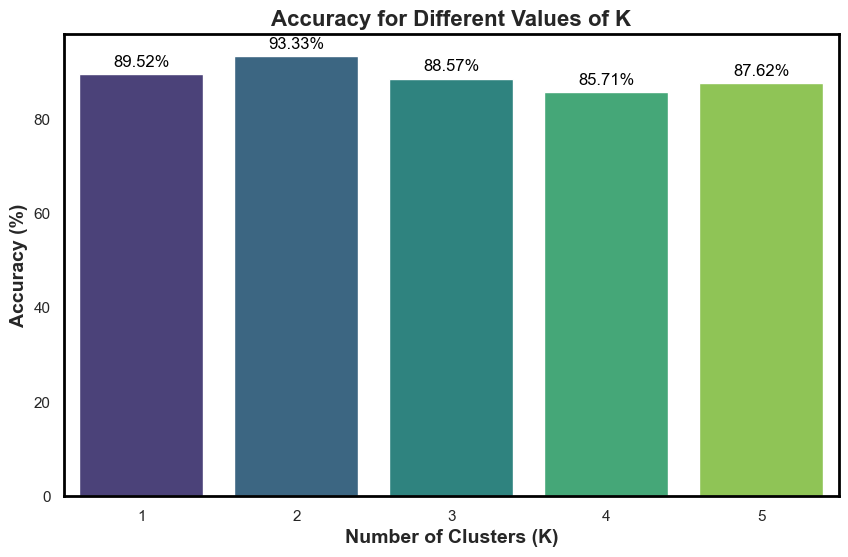

In [8]:
# Suppress warnings during the computation
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Calculate accuracies for different values of K
    k_values = list(range(1, 6))
    accuracies = [find_accuracy_according_to_K(K=k) for k in k_values]

# Create a seaborn bar plot with numerical values
sns.set(style="white")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=k_values, y=[accuracy * 100 for accuracy in accuracies], palette="viridis")

# Set plot border color and width
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_linewidth(2)

# Remove grid lines
ax.grid(False)

# Add numerical values on top of each bar
for i, v in enumerate(accuracies):
    ax.text(i, v * 100 + 1, f'{v * 100:.2f}%', ha='center', va='bottom', color='black')

# Add labels and title with larger font size and bold text
ax.set_title('Accuracy for Different Values of K', fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Clusters (K)', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')

# Show the plot without a grid
plt.show()


### 3.3 Feature vector clustering of vowel a with different K values

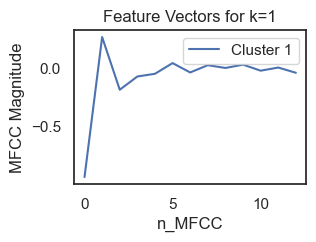

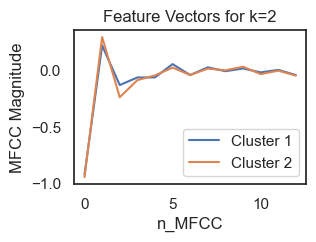

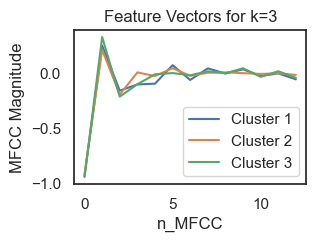

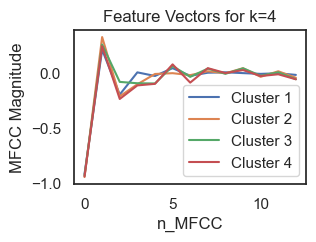

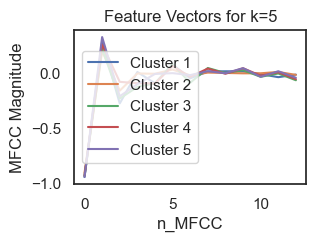

In [9]:
a_vector_with_k_dimension = defaultdict(list)

for k in range(1,6):
    a_vector_with_k_dimension[k] = compute_kmean_feature_vector(TRAINING_DATA, 'a', k)

# Plotting the vectors for each k
for k in range(1, 6):
    feature_vectors = a_vector_with_k_dimension[k]

    # Plotting the vectors
    plt.figure(figsize=(3, 2))
    for i in range(len(feature_vectors)):
        plt.plot(feature_vectors[i], label=f'Cluster {i+1}')

    plt.title(f'Feature Vectors for k={k}')
    plt.xlabel('n_MFCC')
    plt.ylabel('MFCC Magnitude')
    plt.legend()
    plt.grid(False)
    plt.show()


## 4. Validation matrix and Confusion matrix

### 4.1 Validation matrix

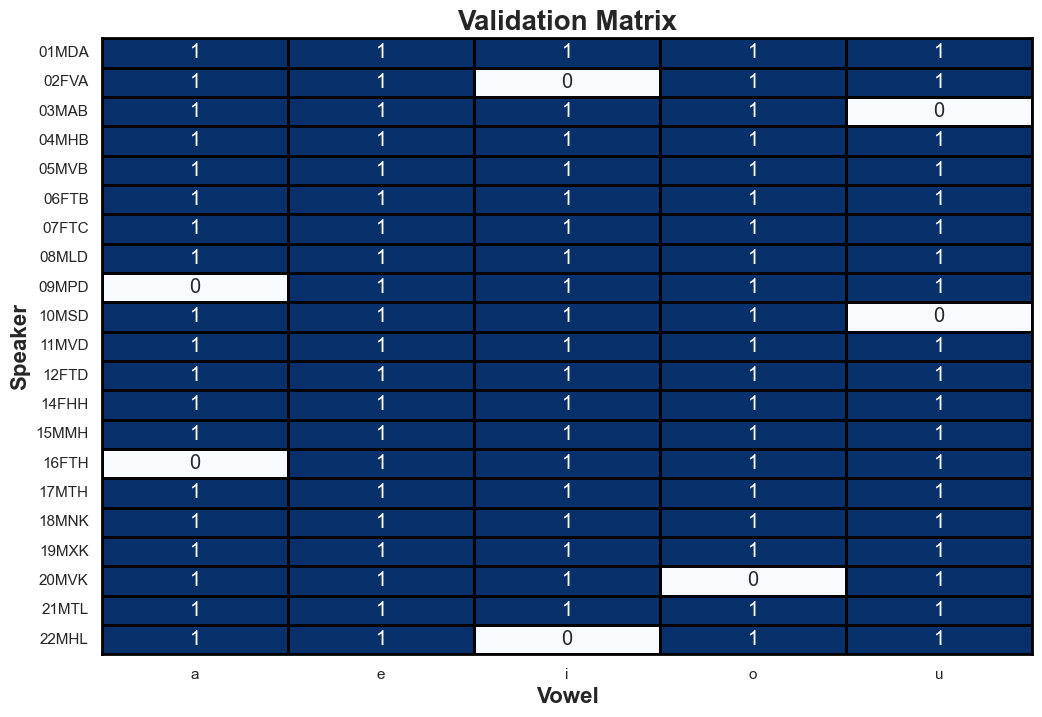

      a e i o u 
01MDA 1 1 1 1 1 
02FVA 1 1 e 1 1 
03MAB 1 1 1 1 e 
04MHB 1 1 1 1 1 
05MVB 1 1 1 1 1 
06FTB 1 1 1 1 1 
07FTC 1 1 1 1 1 
08MLD 1 1 1 1 1 
09MPD o 1 1 1 1 
10MSD 1 1 1 1 i 
11MVD 1 1 1 1 1 
12FTD 1 1 1 1 1 
14FHH 1 1 1 1 1 
15MMH 1 1 1 1 1 
16FTH e 1 1 1 1 
17MTH 1 1 1 1 1 
18MNK 1 1 1 1 1 
19MXK 1 1 1 1 1 
20MVK 1 1 1 u 1 
21MTL 1 1 1 1 1 
22MHL 1 1 u 1 1 


In [10]:
def find_validation_matrix_according_to_K(K=2):
    vowel_kmean_vector = defaultdict(list)
    vowel_kmean_vector['a'] = compute_kmean_feature_vector(TRAINING_DATA, 'a', K)
    vowel_kmean_vector['e'] = compute_kmean_feature_vector(TRAINING_DATA, 'e', K)
    vowel_kmean_vector['i'] = compute_kmean_feature_vector(TRAINING_DATA, 'i', K)
    vowel_kmean_vector['o'] = compute_kmean_feature_vector(TRAINING_DATA, 'o', K)
    vowel_kmean_vector['u'] = compute_kmean_feature_vector(TRAINING_DATA, 'u', K)

    validation_matrix = defaultdict(lambda: defaultdict(lambda: False))
    label_matrix = defaultdict(lambda: defaultdict(lambda:False))
    distance = defaultdict(lambda: 10**9)
    
    for speaker in VALIDATING_DATA:
        for vowel in VOWEL_LIST:
            speaker_feature_vector = extract_speaker_feature_vector(speaker, vowel)
            distance.clear()
            
            for i in range(K):
                distance['a'] = min(distance['a'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['a'][i]))
                distance['e'] = min(distance['e'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['e'][i]))
                distance['i'] = min(distance['i'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['i'][i]))
                distance['o'] = min(distance['o'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['o'][i]))
                distance['u'] = min(distance['u'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['u'][i]))

            min_distance = min(distance.values())
            predicted_vowel = ""
            
            if min_distance == distance['a']:
                predicted_vowel = 'a'
            elif min_distance == distance['e']:
                predicted_vowel = 'e'
            elif min_distance == distance['i']:
                predicted_vowel = 'i'
            elif min_distance == distance['o']:
                predicted_vowel = 'o'
            else:
                predicted_vowel = 'u'
            
            validation_matrix[speaker[-5:]][vowel] = 1 if vowel == predicted_vowel else 0
            label_matrix[speaker[-5:]][vowel] = 1 if vowel == predicted_vowel else predicted_vowel

    return validation_matrix, label_matrix

# Sau khi tính toán validation_matrix
K = 2  # Bạn cần thay đổi giá trị K nếu cần
validation_matrix, label_matrix = find_validation_matrix_according_to_K(K)

# Convert the validation matrix into a DataFrame for visualization
df = pd.DataFrame(validation_matrix).T

# Set the style
sns.set(style="white")

# Create the heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(df, annot=True, cmap='Blues', cbar=False, linewidths=2, linecolor='black')

# Adding a black border around the heatmap
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(2)

# Setting the title and the labels with increased font size
ax.set_title('Validation Matrix', fontsize=20, weight='bold')
ax.set_xlabel('Vowel', fontsize=16, weight='bold')
ax.set_ylabel('Speaker', fontsize=16, weight='bold')

# Increase the font size of the annotations.
for t in ax.texts:
    t.set_size('large')

# Display the plot

plt.show()


# Print column headers (vowels)
print("     ", end=" ")
for vowel in VOWEL_LIST:
    print(vowel, end=" ")
print()

# Print the labeled matrix
for speaker in VALIDATING_DATA:
    print(speaker[-5:], end=" ")  # Print row header (speaker)
    for vowel in VOWEL_LIST:
        print(label_matrix[speaker[-5:]][vowel], end=" ")
    print()

### 4.2 Confusion matrix

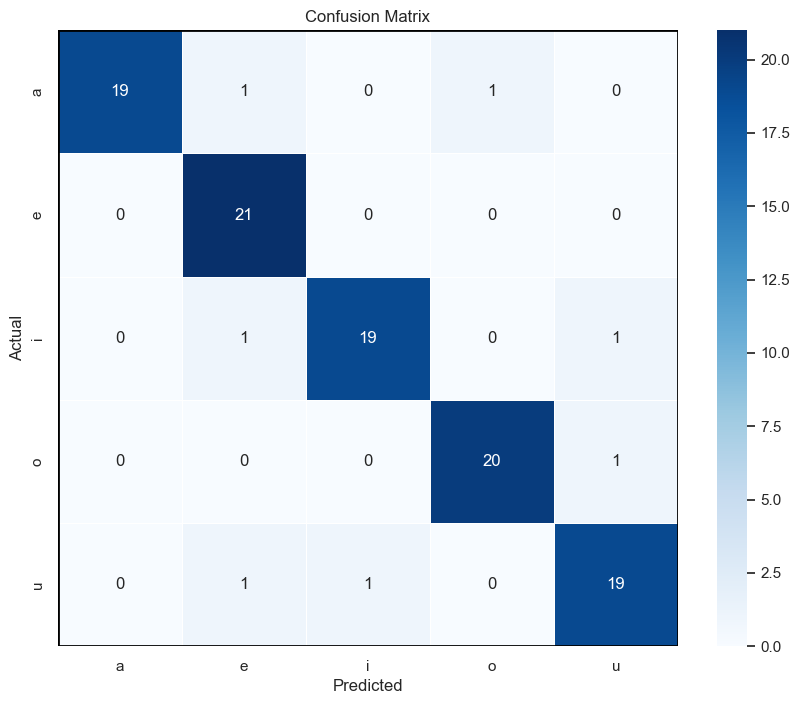

In [11]:
from matplotlib.patches import Rectangle

def find_confusion_matrix_according_to_K(K=2):
    vowel_kmean_vector = defaultdict(list)
    vowel_kmean_vector['a'] = compute_kmean_feature_vector(TRAINING_DATA, 'a', K)
    vowel_kmean_vector['e'] = compute_kmean_feature_vector(TRAINING_DATA, 'e', K)
    vowel_kmean_vector['i'] = compute_kmean_feature_vector(TRAINING_DATA, 'i', K)
    vowel_kmean_vector['o'] = compute_kmean_feature_vector(TRAINING_DATA, 'o', K)
    vowel_kmean_vector['u'] = compute_kmean_feature_vector(TRAINING_DATA, 'u', K)

    confusion_matrix = defaultdict(lambda: defaultdict(lambda: 0))
    distance = defaultdict(lambda: 10**9)
    
    for speaker in VALIDATING_DATA:
        for vowel in VOWEL_LIST:
            speaker_feature_vector = extract_speaker_feature_vector(speaker, vowel)
            distance.clear()
            
            for i in range(K):
                distance['a'] = min(distance['a'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['a'][i]))
                distance['e'] = min(distance['e'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['e'][i]))
                distance['i'] = min(distance['i'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['i'][i]))
                distance['o'] = min(distance['o'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['o'][i]))
                distance['u'] = min(distance['u'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['u'][i]))

            min_distance = min(distance.values())
            predicted_vowel = ""
            
            if min_distance == distance['a']:
                predicted_vowel = 'a'
            elif min_distance == distance['e']:
                predicted_vowel = 'e'
            elif min_distance == distance['i']:
                predicted_vowel = 'i'
            elif min_distance == distance['o']:
                predicted_vowel = 'o'
            else:
                predicted_vowel = 'u'
            
            confusion_matrix[vowel][predicted_vowel] += 1
    # Convert the confusion matrix to a DataFrame for better visualization
    df_confusion = pd.DataFrame(confusion_matrix).T
    df_confusion = df_confusion.fillna(0)

    return df_confusion

# Calculate the confusion matrix
K = 2  # Bạn cần thay đổi giá trị K nếu cần
confusion_matrix = find_confusion_matrix_according_to_K(K)

# Since you are using seaborn, we convert the matrix to DataFrame
df_confusion = pd.DataFrame(confusion_matrix).reindex(['a', 'e', 'i', 'o', 'u'])
df_confusion = df_confusion[['a', 'e', 'i', 'o', 'u']].fillna(0)

# Create a seaborn heatmap
plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(df_confusion,
                      annot=True,      # Annotate cells with values
                      cmap='Blues',    # Use blue color scale
                      fmt='g',         # Use general format for the annotation
                      linewidths=0.5,  # Cell border width
                      edgecolor='black' # Border color
                     )
# Add a rectangle with black border to the current axis
current_axis = plt.gca()
current_axis.add_patch(Rectangle((0, 0), width=df_confusion.shape[1], height=df_confusion.shape[0], 
                                 edgecolor='black', facecolor='none', lw=2))

# Set axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Set title
plt.title('Confusion Matrix')

# Show the plot without grid lines
plt.grid(False)  # This is actually redundant as seaborn heatmaps don't show grid lines by default
plt.show()


## 5. Examining FRAMES_MODES, WINDOWN_FUNCTIONS and K_CLUSTERS

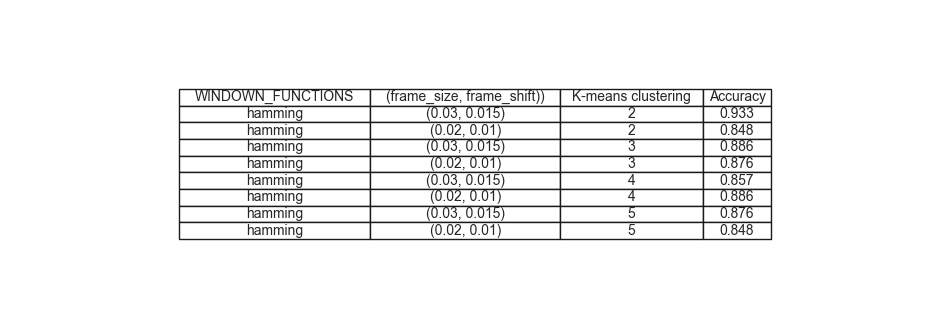

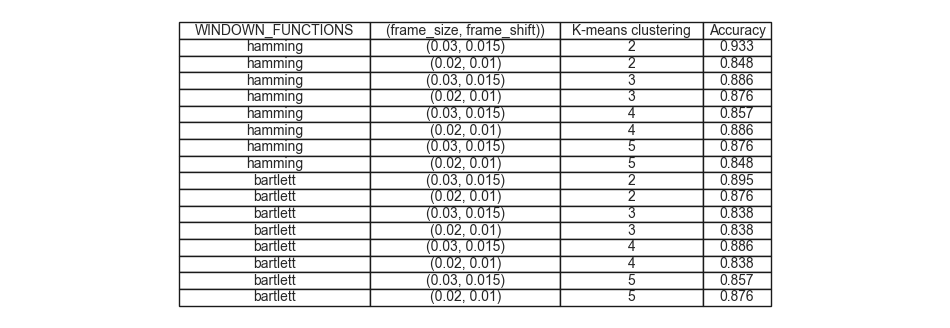

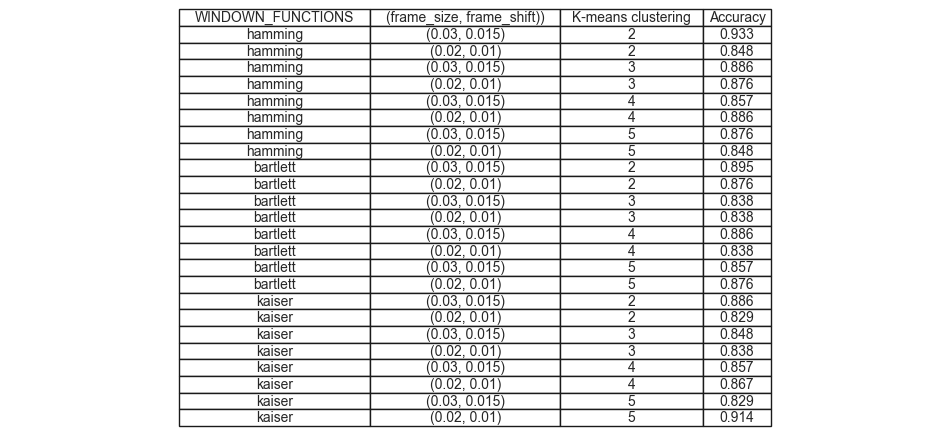

In [12]:
def find_accuracy_according_to_parameter(frame_size, frame_shift, window_function, K):
    FRAME_SIZE = frame_size
    FRAME_SHIFT = frame_shift
    MFCC_POINTS = 13

    def load_audio(file_path):
        try:
            audio, sr = librosa.load(file_path, sr=None)
            return audio, sr
        except Exception as e:
            print(f"Error loading audio: {e}")
            return None, None

    def frame_audio(audio, framesize, frameshift):
        return librosa.util.frame(audio, frame_length=framesize, hop_length=frameshift)

    def compute_ste(framed_audio):
        ste = np.sum(np.square(framed_audio), axis=0)
        ste /= np.max(ste)
        return ste

    def extract_vectorMFCC(audio_signal, sample_rate):
        frame_shift = int(FRAME_SHIFT * sample_rate)
        frame_len = int(FRAME_SIZE * sample_rate)
        frame_num = (len(audio_signal) - frame_len) // frame_shift + 1

        if window_function=='hamming':
            window = hamming(frame_len)
        elif window_function=='bartlett':
            window = bartlett(frame_len)
        elif window_function=='blackman':
            window = blackman(frame_len)
        elif window_function=='kaiser':
            window = kaiser(frame_len, 14)
        elif window_function=='hann':
            window = hann(frame_len)
        mfcc_vectors = []

        for i in range(frame_num):
            start_index = i * frame_shift
            end_index = start_index + frame_len
            frame = audio_signal[start_index:end_index]
            windowed_frame = frame * window

            mfcc_vectors.append(librosa.feature.mfcc(y=windowed_frame, n_fft=512, sr=sample_rate, n_mfcc=MFCC_POINTS).T)

        mfcc_array = np.array(mfcc_vectors)
        normalized_array = mfcc_array / np.max(np.abs(mfcc_array))
        return normalized_array

    def extract_feature_vector(speaker, vowel):
        file_path = f'signals/{speaker}/{vowel}.wav'
        audio, sr = load_audio(file_path)

        framesize = int(FRAME_SIZE * sr)
        frameshift = int(FRAME_SHIFT * sr)

        framed_audio = frame_audio(audio, framesize, frameshift)
        ste = compute_ste(framed_audio)

        left_stable_border, right_stable_border = find_stable_border(ste)

        left_stable_sample = int(left_stable_border * frameshift)
        right_stable_sample = int(right_stable_border * frameshift)

        stable_region = audio[left_stable_sample:right_stable_sample]

        mfcc_vector = extract_vectorMFCC(stable_region, sr)
        return mfcc_vector

    def find_stable_border(ste):
        left_border, right_border = None, None

        for i in range(len(ste)):
            if ste[i] > 0.01:  # Update the threshold as needed
                left_border = i
                break

        for i in range(len(ste) - 1, -1, -1):
            if ste[i] > 0.01:  # Update the threshold as needed
                right_border = i
                break

        left_stable_border = left_border + (right_border - left_border) // 3
        right_stable_border = right_border - (right_border - left_border) // 3

        return left_stable_border, right_stable_border

    def compute_average_feature_vector(speakers, vowel):
        all_feature_vectors = []

        for speaker in speakers:
            feature_vector = extract_feature_vector(speaker, vowel)
            all_feature_vectors.extend(feature_vector)

        all_feature_vectors = np.array(all_feature_vectors)
        normalized_array = all_feature_vectors / np.max(np.abs(all_feature_vectors))
        flattened_array = normalized_array.reshape(normalized_array.shape[0], -1)

        kmeans = KMeans(n_clusters=K, random_state=0)
        kmeans.fit(flattened_array)
        centroids = kmeans.cluster_centers_
        return centroids

    def euclidean_distance(vector1, vector2):
        return np.linalg.norm(vector1 - vector2)

    def find_accuracy(K=2):
        vowel_kmean_vector = defaultdict(list)
        vowel_kmean_vector['a'] = compute_average_feature_vector(TRAINING_DATA, 'a')
        vowel_kmean_vector['e'] = compute_average_feature_vector(TRAINING_DATA, 'e')
        vowel_kmean_vector['i'] = compute_average_feature_vector(TRAINING_DATA, 'i')
        vowel_kmean_vector['o'] = compute_average_feature_vector(TRAINING_DATA, 'o')
        vowel_kmean_vector['u'] = compute_average_feature_vector(TRAINING_DATA, 'u')

        result = []
        distance = defaultdict(lambda: 10**9)
        for speaker in VALIDATING_DATA:
            for vowel in VOWEL_LIST:
                speaker_feature_vector = extract_feature_vector(speaker, vowel)
                distance.clear()
                for i in range(K):
                    distance['a'] = min(distance['a'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['a'][i]))
                    distance['e'] = min(distance['e'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['e'][i]))
                    distance['i'] = min(distance['i'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['i'][i]))
                    distance['o'] = min(distance['o'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['o'][i]))
                    distance['u'] = min(distance['u'], euclidean_distance(speaker_feature_vector, vowel_kmean_vector['u'][i]))

                min_distance = min(distance.values())
                if min_distance == distance['a']:
                    result.append('a' == vowel)
                elif min_distance == distance['e']:
                    result.append('e' == vowel)
                elif min_distance == distance['i']:
                    result.append('i' == vowel)
                elif min_distance == distance['o']:
                    result.append('o' == vowel)
                else:
                    result.append('u' == vowel)

        accuracy = sum(result) / (len(VALIDATING_DATA) * len(VOWEL_LIST))
        return round(accuracy, 3)
    return find_accuracy(K=K)



warnings.filterwarnings("ignore")
data = []
for window_function in WINDOW_FUNCTIONS:
    for k in K_CLUSTERS:
        for frame_size, frame_shift in FRAMES_MODES:
            data.append([window_function, (frame_size, frame_shift), k, find_accuracy_according_to_parameter(frame_size, frame_shift, window_function, k)])
    
    df = pd.DataFrame(data, columns=["WINDOWN_FUNCTIONS", "(frame_size, frame_shift))", "K-means clustering", "Accuracy"])

        
    # Tạo và hiển thị bảng sử dụng matplotlib

    fig, ax = plt.subplots(figsize=(12, 4))  # Điều chỉnh kích thước bảng theo ý muốn

    ax.axis('off')

    table = ax.table(cellText=df.values,

                        colLabels=df.columns,

                        loc='center',

                        cellLoc='center')

    # Điều chỉnh kích cỡ font, chiều rộng cột cho phù hợp

    table.auto_set_font_size(False)

    table.set_fontsize(10)

    table.auto_set_column_width(col=list(range(len(df.columns))))

    plt.show()
